In [1]:
%reload_ext autoreload
%autoreload 2

In [155]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import scipy.stats as stats
from scipy.signal import gaussian
import scipy.signal as scs

In [3]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [4]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

df = replay_run.load_results(save_path)

In [5]:
df = df[(df.decoding_r2_pval < 0.05) & (df.decoding_median_error < 30)]


In [49]:
df

,start,stop,peaks,amplitude,duration,frequency,detectorName,ripple_channel,event_spk_thres,basepath,...,traj_dist,traj_speed,traj_step,replay_type,pop_partic,decoding_r2,decoding_r2_pval,decoding_median_error,total_units,direction
0,23.8224,23.9336,23.8744,222.308225,0.1112,125.155486,bz_DetectSWR,170,0,Z:\Data\AYAold\AB1\day1,...,10.800000,135.000000,2.700000,reverse,0.395833,0.450639,0.003984,7.174326,48.0,outbound_epochs
1,24.4328,24.5312,24.4688,271.271239,0.0984,164.563229,bz_DetectSWR,170,0,Z:\Data\AYAold\AB1\day1,...,22.500000,375.000000,7.500000,reverse,0.291667,0.450639,0.003984,7.174326,48.0,outbound_epochs
2,39.3824,39.4784,39.4448,231.112969,0.0960,133.438614,bz_DetectSWR,170,0,Z:\Data\AYAold\AB1\day1,...,2.700000,45.000000,0.900000,reverse,0.354167,0.450639,0.003984,7.174326,48.0,outbound_epochs
3,93.7304,93.8240,93.7936,424.682252,0.0936,140.341788,bz_DetectSWR,170,0,Z:\Data\AYAold\AB1\day1,...,44.100000,735.000000,14.700000,forward,0.333333,0.450639,0.003984,7.174326,48.0,outbound_epochs
4,138.1160,138.2176,138.1664,237.966913,0.1016,156.368208,bz_DetectSWR,170,0,Z:\Data\AYAold\AB1\day1,...,40.800000,510.000000,10.200000,forward,0.437500,0.450639,0.003984,7.174326,48.0,outbound_epochs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104934,24851.7496,24851.8352,24851.8056,607.664477,0.0856,139.636694,bz_DetectSWR,49,1,Z:\Data\OMLproject\OML18\day1,...,179.837037,2997.283951,59.945679,forward,0.333333,0.439852,0.003984,21.321686,15.0,outbound_epochs
104935,24889.5744,24889.6672,24889.6328,638.731262,0.0928,155.196670,bz_DetectSWR,49,1,Z:\Data\OMLproject\OML18\day1,...,105.432099,2635.802469,52.716049,reverse,0.333333,0.439852,0.003984,21.321686,15.0,outbound_epochs
104936,25905.0880,25905.2264,25905.1176,961.198630,0.1384,127.430503,bz_DetectSWR,49,1,Z:\Data\OMLproject\OML18\day1,...,6.830319,68.303187,1.707580,forward,0.333333,0.439852,0.003984,21.321686,15.0,outbound_epochs
104937,25986.8752,25986.9600,25986.8960,891.423946,0.0848,127.874274,bz_DetectSWR,49,1,Z:\Data\OMLproject\OML18\day1,...,17.170370,286.172839,5.723457,forward,0.733333,0.439852,0.003984,21.321686,15.0,outbound_epochs


In [48]:
# st._data

In [50]:
bin_width = 0.002
n_bins = 200
times = np.linspace(-(n_bins * bin_width) / 2, (n_bins * bin_width) / 2, n_bins + 1)
psth_sup_rip = pd.DataFrame(index=times, columns=np.arange(1))
psth_deep_rip = psth_sup_rip.copy()
psth_sup_replay = psth_sup_rip.copy()
psth_deep_replay = psth_sup_rip.copy()

for basepath in tqdm(df.basepath.unique()):
    # basepath = df.basepath.unique()[0]
    st, cm = loading.load_spikes(basepath, putativeCellType="Pyr", brainRegion="CA1")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    if "tags_bad_waveform" in cm.columns:
        st._data = st.data[cm.tags_bad_waveform == False]
        cm = cm[cm.tags_bad_waveform == False]

    # sig_replay_idx = df.score_pval_time_swap <= 0.05

    replay_peaks = df[
        (df.basepath == basepath) & (df.score_pval_time_swap <= 0.05)
    ].peaks.values
    ripple_peaks = df[(df.basepath == basepath)].peaks.values

    if (cm.deepSuperficial == "Deep").any():
        st_deep = nel.SpikeTrainArray(
            timestamps=np.sort(np.hstack(st.data[cm.deepSuperficial == "Deep"])),
            fs=st.fs,
        )
        psth_deep_rip = pd.concat(
            [
                psth_deep_rip,
                functions.compute_psth(st_deep.data, ripple_peaks, n_bins=n_bins),
            ],
            axis=1,
        )
        psth_deep_replay = pd.concat(
            [
                psth_deep_replay,
                functions.compute_psth(st_deep.data, replay_peaks, n_bins=n_bins),
            ],
            axis=1,
        )

    if (cm.deepSuperficial == "Superficial").any():
        st_sup = nel.SpikeTrainArray(
            timestamps=np.sort(np.hstack(st.data[cm.deepSuperficial == "Superficial"])),
            fs=st.fs,
        )
        psth_sup_rip = pd.concat(
            [
                psth_sup_rip,
                functions.compute_psth(st_sup.data, ripple_peaks, n_bins=n_bins),
            ],
            axis=1,
        )
        psth_sup_replay = pd.concat(
            [
                psth_sup_replay,
                functions.compute_psth(st_sup.data, replay_peaks, n_bins=n_bins),
            ],
            axis=1,
        )


100%|██████████| 64/64 [04:58<00:00,  4.66s/it]


In [138]:
psth_deep_rip = psth_deep_rip.dropna(axis=1, how="all")
psth_deep_replay = psth_deep_replay.dropna(axis=1, how="all")
psth_sup_rip = psth_sup_rip.dropna(axis=1, how="all")
psth_sup_replay = psth_sup_replay.dropna(axis=1, how="all")



In [166]:
def hollow_kernel(kernlen, width, hollow_fraction=0.6, kerntype='gaussian'):
    '''
    Returns a hollow kernel normalized to it's sum
    Parameters
    ----------
    kernlen : int
        Length of kernel, must be uneven (kernlen % 2 == 1)
    width : float
        Width of kernel (std if gaussian)
    hollow_fraction : float
        Fractoin of the central bin to removed.
    Returns
    -------
    kernel : array
    Authors
    -------
    Tristan Stoeber, Mikkel Lepperød
    '''
    if kerntype == 'gaussian':
        assert kernlen % 2 == 1
        kernel = gaussian(kernlen, width)
        kernel[int(kernlen / 2.)] *= (1 - hollow_fraction)
    else:
        raise NotImplementedError
    return kernel / sum(kernel)

def cch_convolve(cch, width, hollow_fraction, kerntype):
    
    kernlen = len(cch) - 2
    kernel = hollow_kernel(kernlen, width, hollow_fraction, kerntype)
    # padd edges
    len_padd = int(kernlen / 2.)
    cch_padded = np.zeros(len(cch) + 2 * len_padd)
    # "firstW/2 bins (excluding the very first bin) are duplicated,
    # reversed in time, and prepended to the cch prior to convolving"
    cch_padded[0:len_padd] = cch[1:len_padd+1][::-1]
    cch_padded[len_padd: - len_padd] = cch
    # # "Likewise, the lastW/2 bins aresymmetrically appended to the cch."
    cch_padded[-len_padd:] = cch[-len_padd-1:-1][::-1]
    # convolve cch with kernel
    result = scs.fftconvolve(cch_padded, kernel, mode='valid')
    assert len(cch) == len(result)
    return result

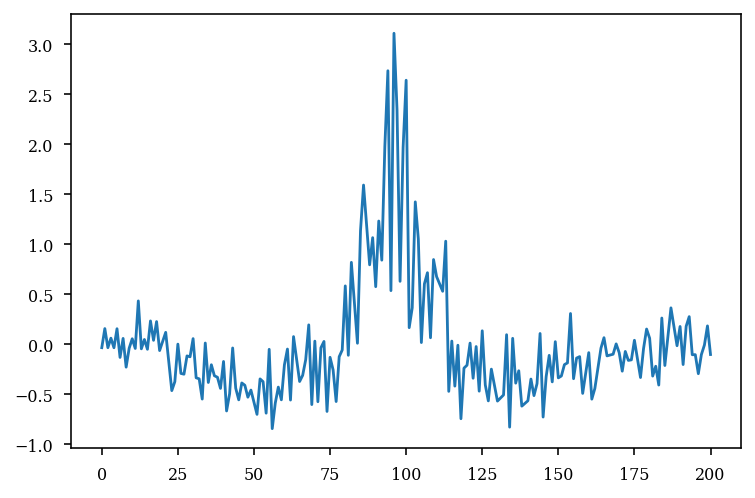

In [172]:
ccg = cch_convolve(psth_deep_rip.iloc[:,0].values, 25, .6, 'gaussian')
plt.plot(psth_deep_rip.iloc[:,0].values - ccg)

In [145]:
psth_deep_rip = stats.zscore(psth_deep_rip,axis=0)
psth_deep_replay = stats.zscore(psth_deep_replay,axis=0)
psth_sup_rip = stats.zscore(psth_sup_rip,axis=0)
psth_sup_replay = stats.zscore(psth_sup_replay,axis=0)



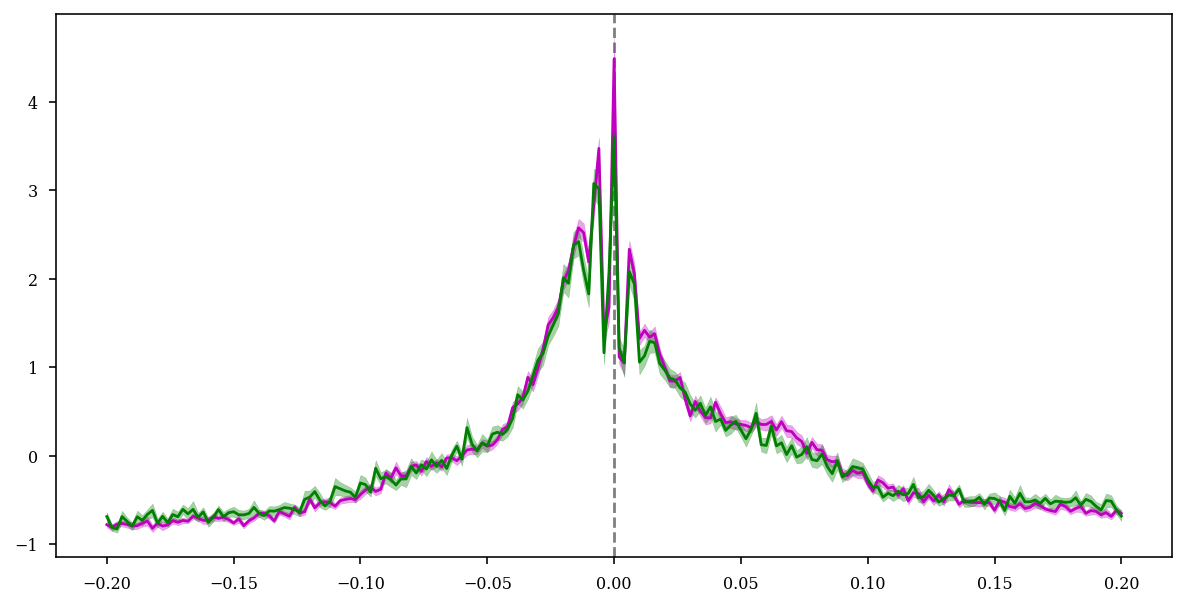

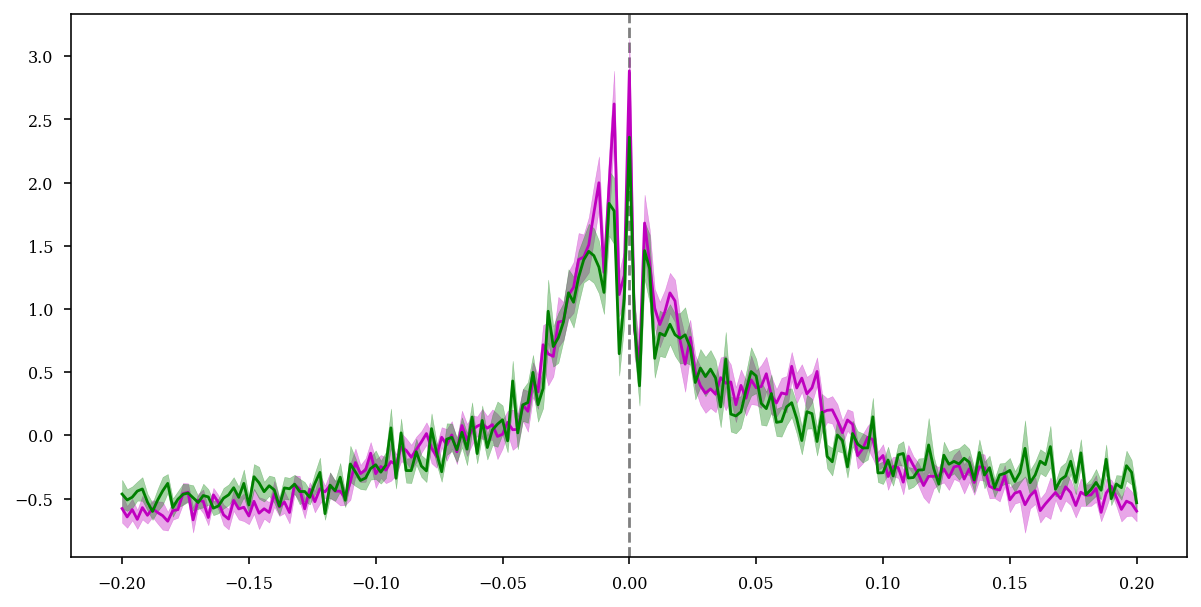

In [148]:
plt.figure(figsize=(10,5))

ax = plt.gca()
psth_deep_rip.mean(axis=1).plot(ax=ax, color="m", label="Deep")
sem = psth_deep_rip.std(axis=1) / np.sqrt(psth_deep_rip.shape[1])
ax.fill_between(
    psth_deep_rip.index,
    psth_deep_rip.mean(axis=1) - sem,
    psth_deep_rip.mean(axis=1) + sem,
    alpha=0.35,
    color="m",
)
psth_sup_rip.mean(axis=1).plot(ax=ax, color="g", label="Superficial")
sem = psth_sup_rip.std(axis=1) / np.sqrt(psth_sup_rip.shape[1])
ax.fill_between(
    psth_sup_rip.index,
    psth_sup_rip.mean(axis=1) - sem,
    psth_sup_rip.mean(axis=1) + sem,
    alpha=0.35,
    color="g",
)
ax.axvline(0, color="k", linestyle="--",alpha=.5,zorder=-100)


plt.figure(figsize=(10,5))
ax = plt.gca()
psth_deep_replay.mean(axis=1).plot(ax=ax, color="m", label="Deep")
sem = psth_sup_replay.std(axis=1) / np.sqrt(psth_sup_replay.shape[1])
ax.fill_between(
    psth_deep_replay.index,
    psth_deep_replay.mean(axis=1) - sem,
    psth_deep_replay.mean(axis=1) + sem,
    alpha=0.35,
    color="m",
)
psth_sup_replay.mean(axis=1).plot(ax=ax, color="g", label="Superficial")
sem = psth_sup_replay.std(axis=1) / np.sqrt(psth_sup_replay.shape[1])
ax.fill_between(
    psth_sup_replay.index,
    psth_sup_replay.mean(axis=1) - sem,
    psth_sup_replay.mean(axis=1) + sem,
    alpha=0.35,
    color="g",
)
ax.axvline(0, color="k", linestyle="--",alpha=.5,zorder=-100)